In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

import soundfile as sf
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from scipy.io import wavfile
import scipy.signal
from PIL import Image
import shutil

In [ ]:
#import noisereduce as nr
from imblearn.over_sampling import SMOTE
from scipy.signal import lfilter, butter
#import keras_tuner as kt
#from kerastuner import HyperModel
#from keras_tuner import RandomSearch

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
#from hmmlearn import hmm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from scipy.stats import uniform, randint
from keras import optimizers
from keras import losses


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras import regularizers
from sklearn.neural_network import MLPClassifier
from keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras import layers, models
from tensorflow.keras.layers import SimpleRNN
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.layers import  Bidirectional,RepeatVector, TimeDistributed
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

from keras.layers import BatchNormalization

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 98% 422M/429M [00:04<00:00, 91.3MB/s]
100% 429M/429M [00:05<00:00, 89.4MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/ravdess-emotional-speech-audio.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/audio_speech_actors_01-24'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        parts = filename.split('-')

        if len(parts) >= 3:
            label = parts[2]  # Get the 3rd term
            labels.append(label)
        else:
            print(f"Skipping file with unexpected format: {filename}")

In [ ]:
## Create a RAVDESS dataframe
df= pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/audio_speech_actors_01-24/Actor_19/03...,07
1,/content/audio_speech_actors_01-24/Actor_19/03...,08
2,/content/audio_speech_actors_01-24/Actor_19/03...,04
3,/content/audio_speech_actors_01-24/Actor_19/03...,04
4,/content/audio_speech_actors_01-24/Actor_19/03...,04


In [ ]:
# Define preprocessing parameters
TARGET_SAMPLE_RATE = 48000   # Desired sample rate for resampling
FRAME_SIZE = 1200            # Frame size in samples (25 ms)
HOP_LENGTH = 600             # Hop length in samples (50% overlap)
MFCC_N_MFCC = 13             # Number of MFCC coefficients to extract
PAD_LENGTH = 5 * TARGET_SAMPLE_RATE

In [ ]:
# Function to preprocess audio
def preprocess_audio(file_path, target_sr=TARGET_SAMPLE_RATE, pad_length=PAD_LENGTH):
    # Load the audio
    y, sr = librosa.load(file_path, sr=target_sr)

    # Step 1: Silence Removal (Using librosa.effects.trim)
    y, _ = librosa.effects.trim(y)

    # Step 2: Padding (if the audio is shorter than the target length)
    if len(y) < pad_length:
        padding = pad_length - len(y)
        y = np.pad(y, (0, padding), 'constant')  # Zero padding at the end

    # Step 3: Normalization (Peak normalization to [-1, 1] range)
    y = librosa.util.normalize(y)

    return y, target_sr


In [ ]:
# Function to extract raw MFCC features
def extract_mfcc(audio, sr, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, n_mfcc=MFCC_N_MFCC):
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    return mfcc

In [ ]:


# Function to extract delta and delta-delta MFCC features
def extract_delta_mfcc(mfcc):
    # Extract delta MFCC (first-order difference)
    delta_mfcc = librosa.feature.delta(mfcc)

    # Extract delta-delta MFCC (second-order difference)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    return delta_mfcc, delta2_mfcc

In [ ]:

# Helper function to pad or truncate features
def pad_or_truncate(features, target_length):
    # If the number of frames is less than the target, pad with zeros
    if features.shape[1] < target_length:
        padding = target_length - features.shape[1]
        return np.pad(features, ((0, 0), (0, padding)), mode='constant')
    # If the number of frames is more than the target, truncate
    elif features.shape[1] > target_length:
        return features[:, :target_length]
    return features

In [ ]:
# Initialize list to store processed data
processed_data = []
target_num_frames = 400  # Set a target number of frames for padding/truncating
scaler = StandardScaler()  # Initialize the scaler

# Assuming df1 is already defined and contains the audio paths and labels
for index, row in df.iterrows():
    audio_path = row['speech']
    label = row['label']

    # Preprocess the audio
    y, sr = preprocess_audio(audio_path)

    # Extract raw MFCC features (shape: (n_mfcc, num_frames))
    raw_mfcc = extract_mfcc(y, sr)

    # Extract delta and delta-delta MFCC features
    delta_mfcc, delta2_mfcc = extract_delta_mfcc(raw_mfcc)

    # Pad or truncate MFCC, delta MFCC, and delta-delta MFCC to ensure consistent number of frames
    adjusted_mfcc = pad_or_truncate(raw_mfcc, target_num_frames)
    adjusted_delta_mfcc = pad_or_truncate(delta_mfcc, target_num_frames)
    adjusted_delta2_mfcc = pad_or_truncate(delta2_mfcc, target_num_frames)

    # Transpose the MFCC arrays to fit the (num_frames, num_mfcc) format
    adjusted_mfcc = adjusted_mfcc.T
    adjusted_delta_mfcc = adjusted_delta_mfcc.T
    adjusted_delta2_mfcc = adjusted_delta2_mfcc.T

    # Normalize each frame's MFCC, delta MFCC, and delta-delta MFCC (standardize)
    scaled_mfcc = scaler.fit_transform(adjusted_mfcc)
    scaled_delta_mfcc = scaler.fit_transform(adjusted_delta_mfcc)
    scaled_delta2_mfcc = scaler.fit_transform(adjusted_delta2_mfcc)

    # Combine MFCC, delta MFCC, and delta-delta MFCC features (num_frames, num_mfcc * 3)
    combined_features = np.hstack([scaled_mfcc, scaled_delta_mfcc, scaled_delta2_mfcc])

    # Append the combined features and label to processed_data
    processed_data.append((combined_features, label))

In [ ]:
 #Create separate lists for features and labels
X = [item[0] for item in processed_data]  # List of feature arrays (MFCCs + delta + delta-delta)
y = [item[1] for item in processed_data]  # Corresponding labels

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Apply one-hot encoding to the labels
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Now X_train and X_test contain the combined MFCC, delta, and delta-delta features,
# and y_train and y_test contain one-hot encoded labels
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1152, 400, 39)
X_test shape: (288, 400, 39)
y_train shape: (1152, 8)
y_test shape: (288, 8)


In [ ]:
# Input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (num_frames, num_mfcc)
print("Input shape:", input_shape)

# Number of classes
num_classes = y_train.shape[1]  # Number of unique classes
print("Number of classes:", num_classes)

Input shape: (400, 39)
Number of classes: 8


###LSTM with attenstion

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model1(input_shape, num_classes):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Add Attention layer
    model.add(Attention())

    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimozer=Adam(learning_rate=0.0001)
    model.compile(optimizer=optimozer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Model summary
model_with_attention = build_lstm_attention_model1(input_shape, num_classes)
model_with_attention.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 400, 512)            │       1,130,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 400, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 400, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 400, 128)            │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 400, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 400, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 128)                 │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,475,224 (5.63 MB)

 Trainable params: 1,473,688 (5.62 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
# Training the model with attention
history_attention = model_with_attention.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.1371 - loss: 2.7180 - val_accuracy: 0.1632 - val_loss: 2.0701
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.2379 - loss: 2.3525 - val_accuracy: 0.1632 - val_loss: 2.0627
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.2629 - loss: 2.1876 - val_accuracy: 0.1632 - val_loss: 2.0545
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.3210 - loss: 1.9830 - val_accuracy: 0.1632 - val_loss: 2.0505
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.3121 - loss: 1.9789 - val_accuracy: 0.1632 - val_loss: 2.0455
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.3749 - loss: 1.8215 - val_accuracy: 0.1632 - val_loss: 2.0443
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.3754 - loss: 1.7378 - val_accuracy: 0.1632 - val_loss: 2.0394
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.4587 - loss: 1.5530 - val_acc

### Parameter tunning using optuna

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
#Attention alyer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    lstm_units_1 = trial.suggest_int('lstm_units_1', 128, 512)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 64, 256)
    dense_units = trial.suggest_int('dense_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    # Build model
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(lstm_units_1, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(lstm_units_2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Add Attention layer
    model.add(Attention())

    # Fully connected layer
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=20,  # Use a smaller number for Optuna trials
                        batch_size=64,
                        validation_data=(X_test, y_test),
                        verbose=0)  # Don't print the training logs for each trial

    # Return the validation accuracy of the last epoch
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy

In [ ]:
# Create a study and optimize the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-09-28 04:22:27,725] A new study created in memory with name: no-name-2ceb6e65-0d5e-4ce3-b56b-a022da741098
[I 2024-09-28 05:43:10,032] Trial 0 finished with value: 0.5729166865348816 and parameters: {'lstm_units_1': 512, 'lstm_units_2': 113, 'dense_units': 91, 'dropout_rate': 0.24579098903111718, 'learning_rate': 6.792140693083467e-05}. Best is trial 0 with value: 0.5729166865348816.
[I 2024-09-28 06:29:15,523] Trial 1 finished with value: 0.2395833283662796 and parameters: {'lstm_units_1': 426, 'lstm_units_2': 105, 'dense_units': 42, 'dropout_rate': 0.4039495492397093, 'learning_rate': 1.1657260710844488e-05}. Best is trial 0 with value: 0.5729166865348816.
[I 2024-09-28 07:21:41,874] Trial 2 finished with value: 0.2743055522441864 and parameters: {'lstm_units_1': 441, 'lstm_units_2': 165, 'dense_units': 121, 'dropout_rate': 0.30387721400110324, 'learning_rate': 1.4052990505706368e-05}. Best is trial 0 with value: 0.5729166865348816.
[I 2024-09-28 08:28:16,110] Trial 3 finished

In [ ]:
# Get the best trial and its parameters
print('Best trial:')
trial = study.best_trial
print(f'  Validation Accuracy: {trial.value}')
print('  Best hyperparameters: ', trial.params)


In [ ]:
# Rebuild the model using the best parameters found by Optuna
best_model = Sequential()

# Add LSTM layers
best_model.add(LSTM(trial.params['lstm_units_1'], return_sequences=True, input_shape=input_shape))
best_model.add(BatchNormalization())
best_model.add(Dropout(trial.params['dropout_rate']))

best_model.add(LSTM(trial.params['lstm_units_2'], return_sequences=True))
best_model.add(BatchNormalization())
best_model.add(Dropout(trial.params['dropout_rate']))

# Add Attention layer
best_model.add(Attention())

# Fully connected layers
best_model.add(Dense(trial.params['dense_units'], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(Dropout(trial.params['dropout_rate']))
best_model.add(Dense(trial.params['dense_units'], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(Dropout(trial.params['dropout_rate']))

# Output layer
best_model.add(Dense(num_classes, activation='softmax'))

# Compile the best model
best_optimizer = Adam(learning_rate=trial.params['learning_rate'])
best_model.compile(optimizer=best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the best model on the entire dataset
best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))


### LSTM without Attenstion

In [ ]:
def build_lstm_attention_model1(input_shape, num_classes):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(LSTM(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimozer=Adam(learning_rate=0.0001)
    model.compile(optimizer=optimozer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Model summary
model_without_attention = build_lstm_attention_model1(input_shape, num_classes)
model_without_attention.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 400, 512)            │       1,130,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 400, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 400, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,474,696 (5.63 MB)

 Trainable params: 1,473,160 (5.62 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
import numpy as np
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
# Training the model with attention
history_attention = model_without_attention.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.1154 - loss: 3.0917 - val_accuracy: 0.1562 - val_loss: 2.0669
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.1508 - loss: 2.6638 - val_accuracy: 0.2326 - val_loss: 2.0478
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.1752 - loss: 2.6490 - val_accuracy: 0.2604 - val_loss: 2.0349
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.2091 - loss: 2.4439 - val_accuracy: 0.2569 - val_loss: 2.0232
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.2323 - loss: 2.3565 - val_accuracy: 0.2917 - val_loss: 2.0115
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.2159 - loss: 2.2946 - val_accuracy: 0.2708 - val_loss: 1.9973
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.2455 - loss: 2.2355 - val_accuracy: 0.3125 - val_loss: 1.9810
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.2614 - loss: 2.2699 - val_accu

### LSTM GRU with attenstion

In [ ]:
def build_lstm_attention_model2(input_shape, num_classes):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    model.add(GRU(412, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(LSTM(312, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(LSTM(256, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Add Attention layer
    model.add(Attention())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimozer=Adam(learning_rate=0.0001)
    model.compile(optimizer=optimozer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Model summary
model_with_attention = build_lstm_attention_model2(input_shape, num_classes)
model_with_attention.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 400, 512)            │       1,130,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 400, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 400, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 400, 412)            │       1,144,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 400, 412)            │           1,648 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 400, 412)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 400, 312)            │         904,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 400, 312)            │           1,248 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 400, 312)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 400, 256)            │         582,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 400, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 400, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_1 (Attention)              │ (None, 256)                 │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,811,552 (14.54 MB)

 Trainable params: 3,808,184 (14.53 MB)

 Non-trainable params: 3,368 (13.16 KB)

In [ ]:
# Training the model with attention
history_attention = model_with_attention.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 925ms/step - accuracy: 0.1163 - loss: 2.9479 - val_accuracy: 0.1181 - val_loss: 2.0999
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 908ms/step - accuracy: 0.2906 - loss: 2.2016 - val_accuracy: 0.1181 - val_loss: 2.1290
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 968ms/step - accuracy: 0.3243 - loss: 1.8551 - val_accuracy: 0.1840 - val_loss: 2.1566
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 921ms/step - accuracy: 0.4034 - loss: 1.6134 - val_accuracy: 0.1458 - val_loss: 2.1777
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 844ms/step - accuracy: 0.4601 - loss: 1.4890 - val_accuracy: 0.1111 - val_loss: 2.1931
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 851ms/step - accuracy: 0.5091 - loss: 1.3810 - val_accuracy: 0.1076 - val_loss: 2.2221
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 847ms/step - accuracy: 0.5453 - loss: 1.2626 - val_accuracy: 0.0938 - val_loss: 2.2407
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 842ms/step - accuracy: 0.5972 - loss: 1.1231 - 

### GRU with attenstion

In [ ]:
def build_lstm_attention_model4(input_shape, num_classes):
    model = Sequential()

    # Add GRU layers
    model.add(GRU(512, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(GRU(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Add Attention layer
    model.add(Attention())

    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimozer=Adam(learning_rate=0.0001)
    model.compile(optimizer=optimozer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Model summary
model_with_attention = build_lstm_attention_model4(input_shape, num_classes)
model_with_attention.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 400, 512)            │         849,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 400, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 400, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 400, 128)            │         246,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 400, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 400, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_2 (Attention)              │ (None, 128)                 │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,112,472 (4.24 MB)

 Trainable params: 1,110,936 (4.24 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
# Training the model with attention
history_attention = model_with_attention.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.1469 - loss: 2.8860 - val_accuracy: 0.1493 - val_loss: 2.0726
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.1846 - loss: 2.5457 - val_accuracy: 0.1493 - val_loss: 2.0751
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.2132 - loss: 2.3043 - val_accuracy: 0.1493 - val_loss: 2.0815
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.2986 - loss: 2.1674 - val_accuracy: 0.1493 - val_loss: 2.0936
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.3436 - loss: 1.9708 - val_accuracy: 0.1493 - val_loss: 2.1009
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.2971 - loss: 2.0536 - val_accuracy: 0.1493 - val_loss: 2.1101
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.3541 - loss: 1.8454 - val_accuracy: 0.1493 - val_loss: 2.1093
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.3715 - loss: 1.7708 - val_accu

### BLSTM with attenstion

In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
def build_bilstm_model(input_shape, num_classes):
    model = Sequential()

    # Add Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Add Attention layer
    model.add(Attention())

    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer for classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
model = build_bilstm_model(input_shape, num_classes)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 400, 1024)           │       2,260,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 400, 1024)           │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 400, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 400, 256)            │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 400, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 400, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_4 (Attention)              │ (None, 256)                 │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,469,080 (13.23 MB)

 Trainable params: 3,466,264 (13.22 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Training the model with attention
history_attention = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.1697 - loss: 2.7184 - val_accuracy: 0.1667 - val_loss: 2.0554
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.3151 - loss: 2.0877 - val_accuracy: 0.1632 - val_loss: 2.0534
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.3505 - loss: 1.8416 - val_accuracy: 0.1632 - val_loss: 2.0599
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.4029 - loss: 1.7149 - val_accuracy: 0.1632 - val_loss: 2.0680
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.4701 - loss: 1.5038 - val_accuracy: 0.1632 - val_loss: 2.0796
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - accuracy: 0.5089 - loss: 1.3661 - val_accuracy: 0.1632 - val_loss: 2.0842
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.5198 - loss: 1.3446 - val_accuracy: 0.1806 - val_loss: 2.0726
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.5811 - loss: 1.2232 - va

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

In [ ]:
y_pred_prob = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


In [ ]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

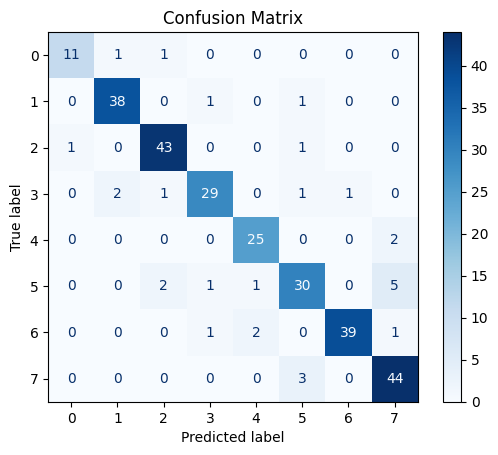

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#2nd bilstm attention model with rmsprop optimizer
def build_bilstm_model1(input_shape, num_classes):
    model = Sequential()

    # Add Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Add Attention layer
    model.add(Attention())

    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer for classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
model = build_bilstm_model1(input_shape, num_classes)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ (None, 400, 1024)           │       2,260,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 400, 1024)           │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 400, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 400, 256)            │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 400, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 400, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_5 (Attention)              │ (None, 256)                 │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,469,080 (13.23 MB)

 Trainable params: 3,466,264 (13.22 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Training the model with attention
history_attention = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.1770 - loss: 2.7342 - val_accuracy: 0.1389 - val_loss: 2.0725
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.3018 - loss: 2.0820 - val_accuracy: 0.1389 - val_loss: 2.0721
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.4290 - loss: 1.6428 - val_accuracy: 0.1389 - val_loss: 2.0830
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.4101 - loss: 1.6167 - val_accuracy: 0.1389 - val_loss: 2.0901
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.5036 - loss: 1.4100 - val_accuracy: 0.1389 - val_loss: 2.0827
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.5325 - loss: 1.3136 - val_accuracy: 0.1389 - val_loss: 2.0804
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.5621 - loss: 1.1963 - val_accuracy: 0.1389 - val_loss: 2.0700
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.6121 - loss: 1.0845 - v

In [ ]:
history=history_attention

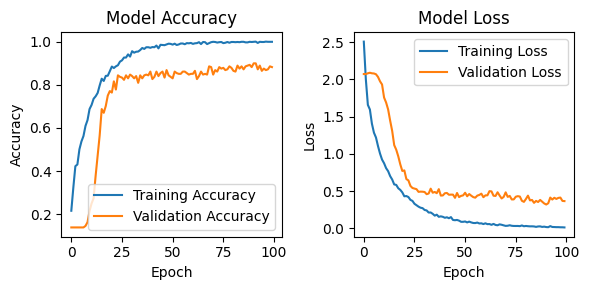

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 3))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show plots
plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


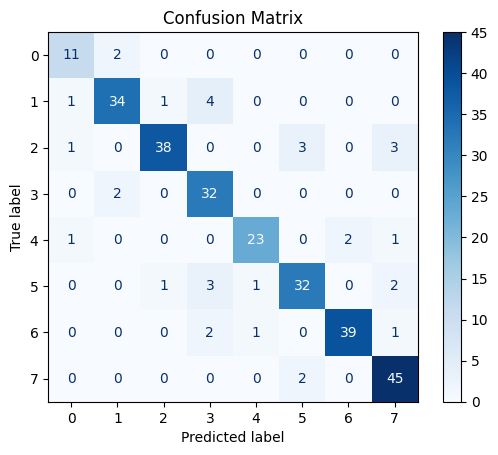

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### 2DCNN+ LSTM with attention

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Reshape

In [ ]:
def build_cnn_lstm_attention_model(input_shape, num_classes):
    model = Sequential()

    # Reshape input to add a channel dimension for Conv2D
    model.add(Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape))  # Adding a channel dimension

    # Add 2D CNN layers for feature extraction
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Flatten to feed into LSTM
    model.add(Reshape((-1, 64)))  # Adjust this based on the CNN output size

    # LSTM layer
    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Add Attention
    model.add(Attention())

    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = build_cnn_lstm_attention_model(input_shape, num_classes)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 400, 39, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 398, 37, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 199, 18, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 199, 18, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 197, 16, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 98, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 98, 8, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 98, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 784, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 784, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 784, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 784, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_6 (Attention)              │ (None, 128)                 │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │              

 Total params: 132,888 (519.09 KB)

 Trainable params: 132,184 (516.34 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Training the model with attention
history_attention = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.1263 - loss: 2.9612 - val_accuracy: 0.1632 - val_loss: 2.0726
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.1269 - loss: 2.6608 - val_accuracy: 0.1632 - val_loss: 2.0720
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.1877 - loss: 2.4587 - val_accuracy: 0.1632 - val_loss: 2.0749
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.1976 - loss: 2.4465 - val_accuracy: 0.1632 - val_loss: 2.0794
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1947 - loss: 2.4107 - val_accuracy: 0.1632 - val_loss: 2.0848
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2211 - loss: 2.3951 - val_accuracy: 0.1632 - val_loss: 2.0911
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.2458 - loss: 2.1986 - val_accuracy: 0.1632 - val_loss: 2.0997
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2345 - loss: 2.3016 - val_accuracy: 